# Coarse-to-Fine NeRF Training

This notebook demonstrates the process through which loss is calculated for the coarse network

In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot as p
from nerf_utils import *
from coarse_network_utils import *

%load_ext autoreload
%autoreload 2
%autosave 180

2024-10-06 22:17:15.609435: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 22:17:16.051806: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-10-06 22:17:16.051883: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/lib:
2024-10-06 22:17:16.051888: W tensorflow/compiler/tf2tensorrt/utils/

Autosaving every 180 seconds


# Calculating Loss for coarse network along a single ray

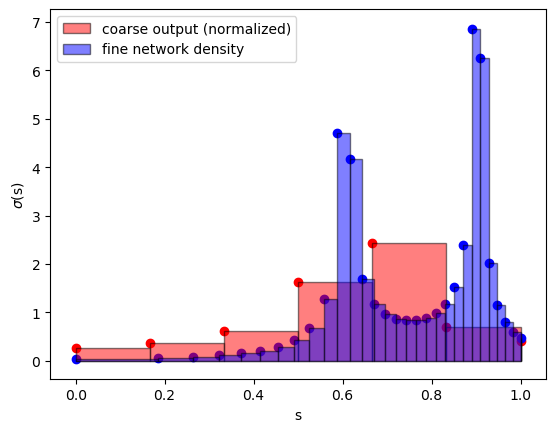

In [2]:
#generate arbitrary histogram for fine network sigma outputs
# note how spacing of sample points is NOT uniform
n_bins_coarse = 7
bins_coarse = np.linspace(0,1,n_bins_coarse)
w_coarse = np.gradient(bins_coarse)
w_coarse[-1] = 0
vals_coarse = abs(1/(0.6 - bins_coarse))
vals_coarse = vals_coarse/np.sum(vals_coarse*w_coarse)

#generate arbitrary coarse network output (which attempts to bound sigma vaules within its range)
n_bins_fine = 30
bins_fine = np.linspace(0,1,n_bins_fine)**0.5
# bins_fine = np.sin(np.linspace(0,1,n_bins_fine))
vals_fine = abs(1/((0.6 - bins_fine)*(0.9 - bins_fine)))
w_fine = np.diff(bins_fine)
w_fine = np.append(w_fine, 0)
vals_fine = vals_fine/np.sum(vals_fine*w_fine)

fig, ax = p.subplots()
ax.bar(bins_coarse+w_coarse/2, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse output (normalized)", alpha = 0.5);
ax.bar(bins_fine+w_fine/2, vals_fine, width = w_fine, color = 'blue', 
       label = "fine network density", edgecolor = 'black', alpha = 0.5);
ax.scatter(bins_coarse, vals_coarse, color = 'red')
ax.scatter(bins_fine, vals_fine, color = 'blue')
ax.set_xlabel("s")
ax.set_ylabel("$\sigma$(s)")
ax.legend(loc="upper left")

L[i] 0.0
L[i] 0.0
L[i] 0.0
L[i] 0.08316307909254511
L[i] 0.0
L[i] 0.29248224272919776
0.3756453218217429


/tmp/ipykernel_82987/1675278127.py:20: RuntimeWarning: invalid value encountered in divide
  ax.bar(bins_coarse+w_coarse/2, L/w_coarse, bottom= vals_coarse,


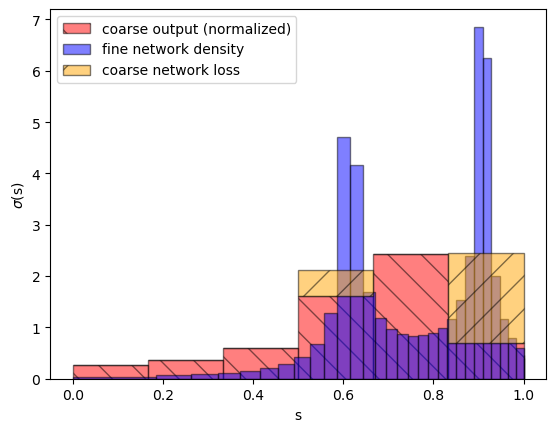

In [3]:
#Calculate loss for a given region in the coarse histogram
L = np.zeros(len(bins_coarse))
for i in range(len(bins_coarse) - 1):
    #get sample locations in fine distribution that fall within bin i of coarse distribution
    small_enough_idx = np.where(bins_fine < bins_coarse[i+1])
    big_enough_idx = np.where(bins_fine >= bins_coarse[i])
    idx_in_range = np.intersect1d(small_enough_idx, big_enough_idx)

    fine_in_bin = np.sum(vals_fine[idx_in_range]*w_fine[idx_in_range])
    L[i] = max(0, fine_in_bin -  vals_coarse[i]*w_coarse[i])
    print("L[i]", L[i])
print(np.sum(L))

fig, ax = p.subplots()
ax.bar(bins_coarse+w_coarse/2, vals_coarse , width = w_coarse, 
       color ='red', edgecolor = 'black', label = "coarse output (normalized)", alpha = 0.5, hatch = '\\');
ax.bar(bins_fine+w_fine/2, vals_fine, width = w_fine, color = 'blue', 
       label = "fine network density", edgecolor = 'black', alpha = 0.5);

ax.bar(bins_coarse+w_coarse/2, L/w_coarse, bottom= vals_coarse, 
       width = w_coarse, color = 'orange', alpha = 0.5, label = "coarse network loss",
       hatch='/', edgecolor = 'black')
ax.set_xlabel("s")
ax.set_ylabel("$\sigma$(s)")
ax.legend(loc="upper left")

# Recreating the above process in parallel using tensorflow
When training our NeRF, we batch rays in "patches" that consist of cropped depth scans of size [H,W]. 
We use tensorflow to do the above loss calculation in parallel for each ray in a patch at once

In [4]:
#make arbitrary fine distributions (what the fine netork produces in its representation of the scene)
#  these vary in inferred density as well as sampling location
H = 64
W = 8
n_bins_fine = 64
n_bins_coarse = 8

#create random sinusoidal peaks
randy = np.pi*tf.random.uniform([H,W, 2])
randy2 = np.pi*tf.cast(tf.random.uniform([H,W, 2]),tf.float32) 

# print(np.shape(randy))
lin = tf.cast(tf.linspace(0,1,n_bins_fine), tf.float32)
lin = tf.tile(lin[None,None,:,None], [H,W,1,1])
weights_fine = (tf.math.sin(randy[...,:1,None]*np.pi*lin + randy[...,1:2,None]) +1)/2

z_vals_coarse = tf.cast(tf.linspace(0,1,n_bins_coarse), tf.float32)
# Also works for nonlinear z values for coarse network
# z_vals_coarse = z_vals_coarse**2 
# z_vals_coarse = tf.math.sin(z_vals_coarse)
z_vals_coarse = tf.tile(z_vals_coarse[None,None,:,None], [H,W,1,1])
weights_coarse = (tf.math.sin(randy[...,:1,None]*np.pi*z_vals_coarse + randy[...,1:2,None]) +1)/2
weights_coarse = weights_coarse/tf.math.reduce_sum(weights_coarse, axis = 2)[:,:,:,None] #normalize to sum to 1

w_coarse = tf.experimental.numpy.diff(z_vals_coarse, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_coarse = tf.pad(w_coarse, padding_config, constant_values=0.001)

#init z_vals [h, w, n_samples, 1]
#create inconsistant spacing for z vals in fine rays
z_vals_fine = (tf.math.sin(3*np.pi*randy2[...,:1,None]*lin + randy2[...,1:,None]) + 2 ) /3
z_vals_fine = tf.cumsum(z_vals_fine, axis = -2)
z_vals_fine -= z_vals_fine[:,:,:1,:]
z_vals_fine /= z_vals_fine[:,:,-1:,:]

w_fine = tf.experimental.numpy.diff(z_vals_fine, axis = 2)
padding_config = [[0, 0],[0, 0],[0, 1],[0, 0]]
w_fine = tf.pad(w_fine, padding_config, constant_values=0.001)

#shift z_vals def to the center
z_vals_coarse = z_vals_coarse + w_coarse/2 
z_vals_fine = z_vals_fine + w_fine/2 

#correct weights so area under the curve is 1
area_fine = tf.math.reduce_sum(weights_fine * w_fine, axis = 2)[:,:,:,None]
weights_fine = weights_fine/area_fine
# print(tf.math.reduce_sum(weights_fine*w_fine, axis = 2))

area_coarse = tf.math.reduce_sum(weights_coarse * w_coarse, axis =2)[:,:,:,None]
weights_coarse = weights_coarse/area_coarse
# print(tf.math.reduce_sum(weights_coarse*w_coarse, axis = 2))

2024-10-06 22:17:20.672884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-06 22:17:20.694688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-06 22:17:20.694885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-06 22:17:20.695384: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Loss of coarse network: tf.Tensor(0.14971219, shape=(), dtype=float32)


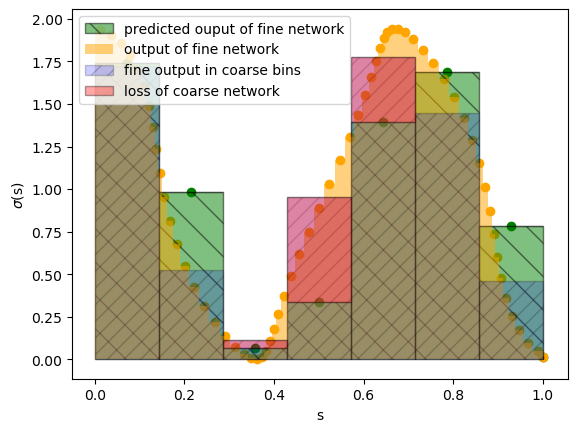

In [5]:
look_at = 0 #select height index of ray in patch to look at

# #left riemann sums
# zc = z_vals_coarse[look_at,0,:,0] 
# zf = z_vals_fine[look_at,0,:,0]
#shift for centered riemann sums
zc = z_vals_coarse[look_at,0,:,0] - w_coarse[look_at,0,:,0]/2 
zf = z_vals_fine[look_at,0,:,0]

#get index of which bin in coarse each bar in fine belongs inside of
indices = tf.searchsorted(zc, zf, side='right')-1

#need to scale L_i by width of coarse bins
fine_sum = tf.math.segment_sum(weights_fine[look_at,0,:,0]*w_fine[look_at,0,:,0], indices)/w_coarse[look_at,0,:,0]

mask = tf.cast(fine_sum > weights_coarse[look_at,0,:,0], tf.float32)
L_i = tf.math.reduce_sum((mask*(fine_sum-weights_coarse[look_at,0,:,0])*w_coarse[look_at,0,:,0]))
print("Loss of coarse network:", L_i)

fig, ax = p.subplots()
ax.scatter(z_vals_coarse[look_at,0,:,0],  weights_coarse[look_at,0,:,0], color  = 'green')
ax.scatter(z_vals_fine[look_at,0,:,0],  weights_fine[look_at,0,:,0], color = 'orange')
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0],label = "predicted ouput of fine network", edgecolor = 'black', 
       alpha = 0.5, hatch = '\\', color = 'green');
ax.bar(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:,0], width = w_fine[look_at,0,:,0], 
   label = "output of fine network", alpha = 0.5, color = 'orange') #, edgecolor = 'black');
ax.bar(z_vals_coarse[look_at,0,:,0], fine_sum, width = w_coarse[look_at,0,:,0], 
   label = "fine output in coarse bins", color = "blue", edgecolor = 'black', hatch = '//', alpha = 0.2);
L_along_ray = mask*((fine_sum-weights_coarse[look_at,0,:,0])) #don't scale (for plotting only)
ax.bar(z_vals_coarse[look_at,0,:,0], L_along_ray,
       width = w_coarse[look_at,0,:,0], bottom = weights_coarse[look_at,0,:,0] ,
       label = "loss of coarse network", color = 'red', edgecolor = 'black', alpha = 0.35);

ax.set_xlabel("s")
ax.set_ylabel("$\sigma$(s)")
ax.legend(loc = 'best');

In [6]:
from coarse_network_utils import * 

loss_coarse = calculate_loss_coarse_network(z_vals_coarse[:,:,:,0], z_vals_fine[:,:,:,0], 
                                     weights_coarse[:,:,:,0], weights_fine[:,:,:,0],
                                     w_coarse[:,:,:,0], w_fine[:,:,:,0] )
print("loss of coarse network using parallel function \n (should be the same as above): \n \n",
      loss_coarse[look_at,0], "\n", np.shape(loss_coarse))

loss of coarse network using parallel function 
 (should be the same as above): 
 
 tf.Tensor(0.14971222, shape=(), dtype=float32) 
 (64, 8)


# Upsampling from coarse to fine distribution

Using the histograms output by the coarse network for each ray in a "patch" resample canidate points to be passed to the fine network

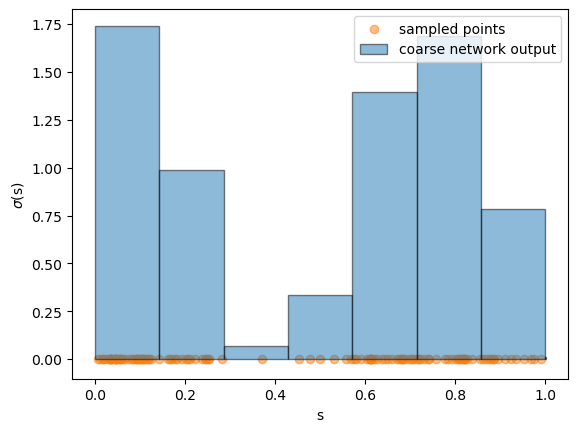

In [7]:
from coarse_network_utils import resample_z_vals

rc = False #guarentee coarse sample locations are a subset of fine samples 
continuous_samples, width_z = resample_z_vals(z_vals_coarse - w_coarse/2, weights_coarse, 
                                              w_coarse, n_resample=128, repeat_coarse=rc)

look_at = 0
fig, ax = p.subplots()
ax.bar(z_vals_coarse[look_at,0,:,0], weights_coarse[look_at,0,:,0], 
       width = w_coarse[look_at,0,:,0], label = "coarse network output", edgecolor = 'black', alpha = 0.5);
ax.scatter(continuous_samples[look_at,0,:], tf.zeros_like(continuous_samples[look_at,0,:]), 
           alpha = 0.5, label = "sampled points");
ax.set_xlabel('s')
ax.set_ylabel('$\sigma$(s)')
ax.legend(loc = 'best');

# ax.plot(z_vals_fine[look_at,0,:,0], weights_fine[look_at,0,:]) #see curve used to generate coarse histograms